In [100]:
from sklearn.linear_model import Ridge
import numpy as np

import sys
import os
script_path = os.path.join(os.path.split(os.getcwd())[0], 'script')
sys.path.insert(0, script_path)
import scatteringTransform as qst
import estimators as qes
import tools as qtl
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import ShuffleSplit

# Scattering model

In [26]:
# data dump required
st_model_data = np.load('st_models_HFn_10k.npz')
st_ols_data = np.load('st_models_HFn_ols_10k.npz')
#_, p_range = qst.loadData('../data/data_m6_10k.pkl', return_range=True) # get padding range 
#dw_data = qst.loadData('../data/data_m6_dw.pkl')
E_train = st_model_data['E'][3]
cv = ShuffleSplit(len(trainset_E), n_iter=10, test_size=.1, random_state=42)

In [2]:
# time: ~ 20min for 206 molecules
testset_features, E_test = qst.stModel_1d_testset('../data/data_m6_10k.pkl', '../data/data_m6_dw.pkl', batch=5)

processing 1 out of 5
63 features
567 features
processing 2 out of 5
63 features
567 features
processing 3 out of 5
63 features
567 features
processing 4 out of 5
63 features
567 features
processing 5 out of 5
63 features
567 features


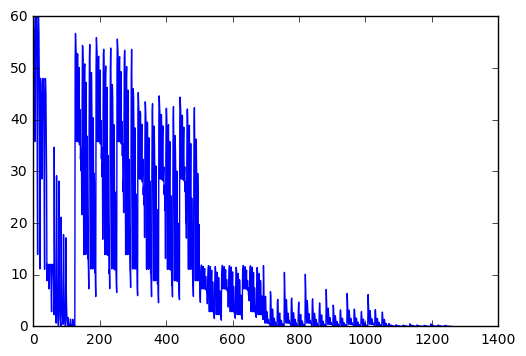

In [67]:
plt.plot(testset_features[:,0])

In [69]:
X_train_st = st_model_data['st'][3]
X_test_st = testset_features

In [21]:
def get_best_components(n):
    return st_ols_data['components_list'][3][:, :n]

def get_regression_matrix(n, cv_i):
    return st_model_data['st'][3][:, get_best_components(n)[cv_i]]

def get_test_features(n, cv_i):
    return testset_features[:, get_best_components(n)[cv_i]]

In [122]:
X_train_st = regression_matrix(500, 0)
X_test_st = get_test_features(500, 0)

In [123]:
st_model = Ridge(alpha=1e-6)
st_model.fit(X_train_st, E_train)

Ridge(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

# KRR model

In [52]:
dw_data = qst.loadData('../data/data_m6_dw.pkl')
hf6_data = qst.loadData('../data/data_m6_10k.pkl')

In [54]:
X_test_kr = qtl.coulomb_matrices(
    dw_data['xyz'], 
    nuclear_charges=dw_data['Z'], 
    sort=False
).reshape(len(dw_data['xyz']),-1)
E_test = dw_data['E']

X_train_kr = qtl.coulomb_matrices(
    hf6_data['xyz'], 
    nuclear_charges=hf6_data['Z'], 
    sort=False
).reshape(len(hf6_data['xyz']),-1)
E_train = hf6_data['E']

In [105]:
kr_model = KernelRidge(alpha=1e-6, kernel='laplacian', gamma=0.001)
kr_model.fit(X_train_kr, E_train)

KernelRidge(alpha=1e-06, coef0=1, degree=3, gamma=0.001, kernel='laplacian',
      kernel_params=None)

# Results

In [ ]:
E_pred_kr = kr_model.predict(X_test_kr)
E_pred_st = st_model.predict(X_test_st)

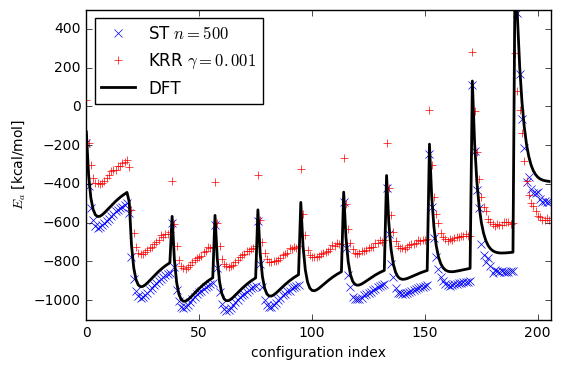

In [125]:
plt.plot(E_pred_st, color='b', marker='x', label='ST $n=500$', ls='')
plt.plot(E_pred_kr, color='r', marker='+', label='KRR $\gamma=0.001$', ls='')
plt.plot(E_test, color='k', lw=2, label='DFT')

plt.ylim(-1100, 500)
plt.xlim(0,206)
plt.legend(loc=2, numpoints=1)
plt.ylabel(r'$E_a$ [kcal/mol]')
plt.xlabel(r'configuration index')

## CV results average

In [141]:
def STKRR(n, cv):
    
    global regression_matrix, E_train, X_train_kr, X_test_kr
    
    st_models = []
    Xs_test_st = []
    kr_models = []
    E_st = []
    E_kr = []
    
    itr = 0
    for train, test in cv:
        print('processing %d fold out of %d' % (itr + 1, cv.n_iter))
    #for i in range(cv.n_iter):
        X_train_st = regression_matrix(500, itr)[train[:n]]
        X_test_st = get_test_features(500, itr)
        st_model = Ridge(alpha=1e-6)
        st_model.fit(X_train_st, E_train[train[:n]])
        E_st.append(st_model.predict(X_test_st))
        
        kr_model = KernelRidge(alpha=1e-6, kernel='laplacian', gamma=0.001)
        kr_model.fit(X_train_kr[train[:n]], E_train[train[:n]])
        E_kr.append(kr_model.predict(X_test_kr))
        
        itr += 1
        
    return np.stack(E_st), np.stack(E_kr)

In [142]:
E_st_7k, E_kr_7k = STKRR(7000, cv)

processing 1 fold out of 10
processing 2 fold out of 10
processing 3 fold out of 10
processing 4 fold out of 10
processing 5 fold out of 10
processing 6 fold out of 10
processing 7 fold out of 10
processing 8 fold out of 10
processing 9 fold out of 10
processing 10 fold out of 10


In [149]:
E_st_1k, E_kr_1k = STKRR(1000, cv)
E_st_5h, E_kr_5h = STKRR(500, cv)
E_st_1h, E_kr_1h = STKRR(100, cv)

processing 1 fold out of 10
processing 2 fold out of 10
processing 3 fold out of 10
processing 4 fold out of 10
processing 5 fold out of 10
processing 6 fold out of 10
processing 7 fold out of 10
processing 8 fold out of 10
processing 9 fold out of 10
processing 10 fold out of 10
processing 1 fold out of 10
processing 2 fold out of 10
processing 3 fold out of 10
processing 4 fold out of 10
processing 5 fold out of 10
processing 6 fold out of 10
processing 7 fold out of 10
processing 8 fold out of 10
processing 9 fold out of 10
processing 10 fold out of 10
processing 1 fold out of 10
processing 2 fold out of 10
processing 3 fold out of 10
processing 4 fold out of 10
processing 5 fold out of 10
processing 6 fold out of 10
processing 7 fold out of 10
processing 8 fold out of 10
processing 9 fold out of 10
processing 10 fold out of 10


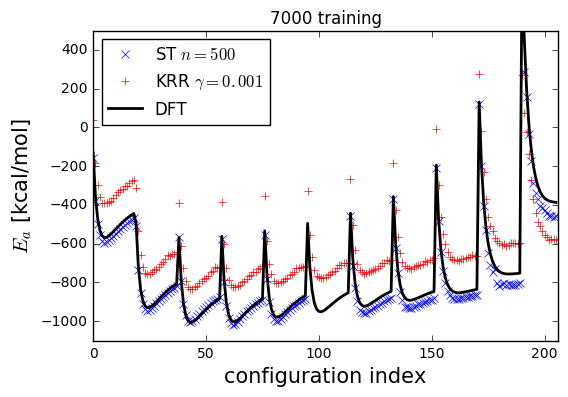

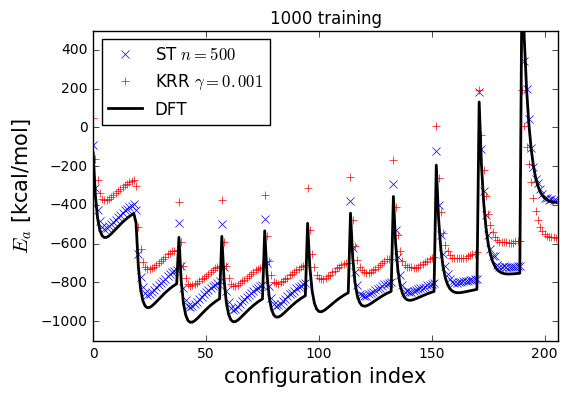

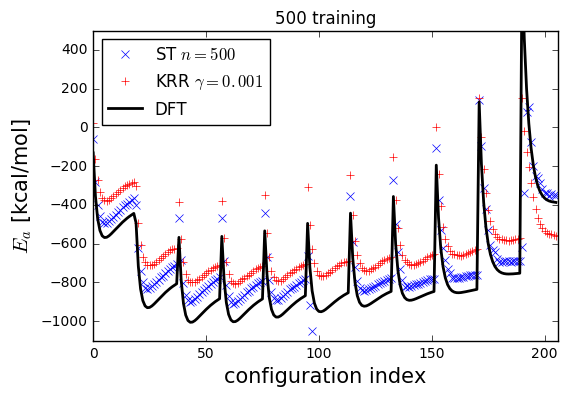

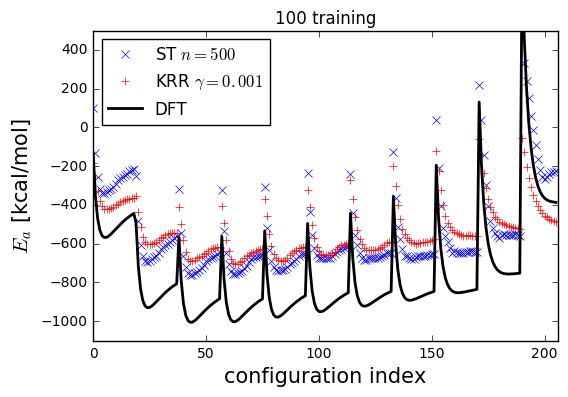

In [165]:
def linearPlot(E_st, E_kr, title=None):
    plt.figure()
    plt.plot(E_st.mean(0), color='b', marker='x', label='ST $n=500$', ls='')
    plt.plot(E_kr.mean(0), color='r', marker='+', label='KRR $\gamma=0.001$', ls='')
    plt.plot(E_test, color='k', lw=2, label='DFT')
    plt.ylim(-1100, 500)
    plt.xlim(0,206)
    plt.legend(loc=2, numpoints=1)
    plt.ylabel(r'$E_a$ [kcal/mol]', fontsize=15)
    plt.xlabel(r'configuration index', fontsize=15)
    plt.title(title)
    
def ravelPlot(E_st, E_kr, title=None):
 
    E_st = np.append(E_st.mean(0), [np.nan, np.nan, np.nan]).reshape(11,19)
    E_kr = np.append(E_kr.mean(0), [np.nan, np.nan, np.nan]).reshape(11,19)
    E_true = np.append(E_test, [np.nan, np.nan, np.nan]).reshape(11,19)
    
    plt.figure()
    
    for i in range(len(E_st)-1):
        Est = E_st[i] - min(E_st[i])
        Ekr = E_kr[i] - min(E_kr[i])
        Et = E_true[i] - min(E_true[i])
        
        plt.plot(Est, color='b', marker='x', label='ST $n=500$')
        plt.plot(Ekr, color='r', marker='+', label='KRR $\gamma=0.001$')
        plt.plot(Et, color='k', lw=2, label='DFT')
    plt.ylim(0, 150)
    #plt.xlim(0,206)
    #plt.legend(loc=2, numpoints=1)
    plt.ylabel(r'$E_a$ [kcal/mol]', fontsize=15)
    plt.xlabel(r'configuration index', fontsize=15)
    plt.title(title)
    
nPlot(E_st_7k,E_kr_7k, '7000 training')
nPlot(E_st_1k,E_kr_1k, '1000 training')
nPlot(E_st_5h,E_kr_5h, '500 training')
nPlot(E_st_1h,E_kr_1h, '100 training')